In [2]:
#from numba import njit
#from scipy.optimize import minimize
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.linalg import eig_banded
import jax
from jax import jit
from tqdm import tqdm
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
jax.config.update("jax_enable_x64", True)


# first derivative approximation via finite difference for various orders of accuracy

@jit
def d2(phi, dx): 
    pad = jnp.concatenate((jnp.array([0]), phi, jnp.array([0])))
    return (pad[2:] - pad[:-2]) / (2*dx)

@jit
def d4(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0]), phi, jnp.array([0,0])))
    return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx

@jit
def d6(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0,0]), phi, jnp.array([0,0,0])))
    return ((1/60)*pad[6:] + (-3/20)*pad[5:-1] + (3/4)*pad[4:-2] + 0*pad[3:-3] + (-3/4)*pad[2:-4] + (3/20)*pad[1:-5] + (-1/60)*pad[:-6])/dx

@jit
def d8(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0,0,0]), phi, jnp.array([0,0,0,0])))
    return ((-1/280)*pad[8:] + (4/105)*pad[7:-1] + (-1/5)*pad[6:-2] + (4/5)*pad[5:-3] + 0*pad[4:-4] + (-4/5)*pad[3:-5] + (1/5)*pad[2:-6] + (-4/105)*pad[1:-7] + (1/280)*pad[:-8])/dx

d = d8

# integration along a axis 0 or 1

@jit
def i0(phi, dx):
    return jnp.trapezoid(phi, dx = dx, axis = 0)

@jit
def i1(phi, dx):
    return jnp.trapezoid(phi, dx = dx, axis = 1)


def solve(xmax, num_points, num_junction, num_island, N, initial_guess, **kwargs):
    nx = num_points
    x = jnp.linspace(-xmax, xmax, nx)
    dx = x[1]-x[0]
    X = x.reshape((nx,1))
    absdiff = jnp.abs(X - X.T) 
    num_pad = (nx - 2 * num_island - num_junction) / 2
    assert(num_pad == int(num_pad))
    num_pad = int(num_pad)
    theta = jnp.concatenate((jnp.zeros(num_pad), jnp.ones(num_island), jnp.zeros(num_junction), jnp.ones(num_island), jnp.zeros(num_pad)))
    a = num_island / nx * 2 * xmax
    L = num_junction / nx * 2 * xmax

    U_ext = i1(absdiff * theta.reshape((1,nx)), dx)

    @jit
    def eps(phi):
        return i0(4*d(phi, dx)**2 + U_ext*phi**2, dx)

    @jit
    def U(phi_i, phi_j, phi_k, phi_l):
        left  = (phi_i*phi_l)
        right = (phi_j*phi_k).reshape(1,nx) 
        return -(a/N) * i0(left*i1(absdiff*right, dx), dx)

    @jit
    def alpha(phi):
        return U(phi, phi, phi, phi)

    @jit
    def beta(phi_p, phi_m):
        return U(phi_p, phi_m, phi_m, phi_p)

    @jit
    def gamma(phi_p, phi_m):
        return U(phi_p, phi_m, phi_p, phi_m)

    @jit
    def unpack(phis_c):
        phi_p, phi_m, c = phis_c[:nx//2], phis_c[nx//2:nx], phis_c[nx:]
        phi_p = jnp.concatenate((jnp.flip(phi_p), phi_p))
        phi_m = jnp.concatenate((-jnp.flip(phi_m), phi_m))
        phi_p = phi_p / jnp.sqrt(i0(phi_p**2, dx))
        phi_m = phi_m / jnp.sqrt(i0(phi_m**2, dx))
        c = c / jnp.sqrt(jnp.sum(c**2))
        return phi_p, phi_m, c

    S = N / 2
    m = jnp.arange(-S, S + 1)
    dim = len(m)
    coeff_plus  = jnp.sqrt(S*(S+1) - m*(m-1))  # S+
    coeff_minus = jnp.sqrt(S*(S+1) - m*(m+1))  # S-

    @jit
    def Sz(c):
        return m*c
    
    @jit
    def Sx(c):
        c_plus  = jnp.concatenate([jnp.array([0.0]), c[:-1]])  # c_{m-1}
        c_minus = jnp.concatenate([c[1:], jnp.array([0.0])])  # c_{m+1}
        return 0.5 * (coeff_plus * c_plus + coeff_minus * c_minus)

    @jit
    def H(phis_c):
        phi_p, phi_m, c = unpack(phis_c)
        Eps_p = eps(phi_p)
        Eps_m = eps(phi_m)
        Alpha_p = alpha(phi_p)
        Alpha_m = alpha(phi_m)
        Beta = beta(phi_p, phi_m)
        Gamma = gamma(phi_p, phi_m)
        E0 = ((Eps_p + Eps_m)/2 + (N/2-1)*(Alpha_p + Alpha_m)/2 + (N/2)*Beta - Gamma) # * N

        x1 = 0
        x2 = 4*Gamma/N
        z1 = (Eps_p - Eps_m + (N-1)*(Alpha_p - Alpha_m))/N
        z2 = (Alpha_p + Alpha_m - 2*Beta)/N

        Sx_c = Sx(c)
        Sx2_c = Sx(Sx_c)
        Sz_c = Sz(c)
        Sz2_c = Sz(Sz_c)

        return E0 + jnp.dot(c, x1*Sx_c + x2*Sx2_c + z1*Sz_c + z2*Sz2_c)


    if initial_guess is None:
        initial_guess = jnp.concatenate((theta[nx//2:], theta[nx//2:], jnp.zeros(dim-1), jnp.ones(1)))
    solver = LBFGS(fun=H, **kwargs)
    result = solver.run(initial_guess)
    return unpack(result.params)

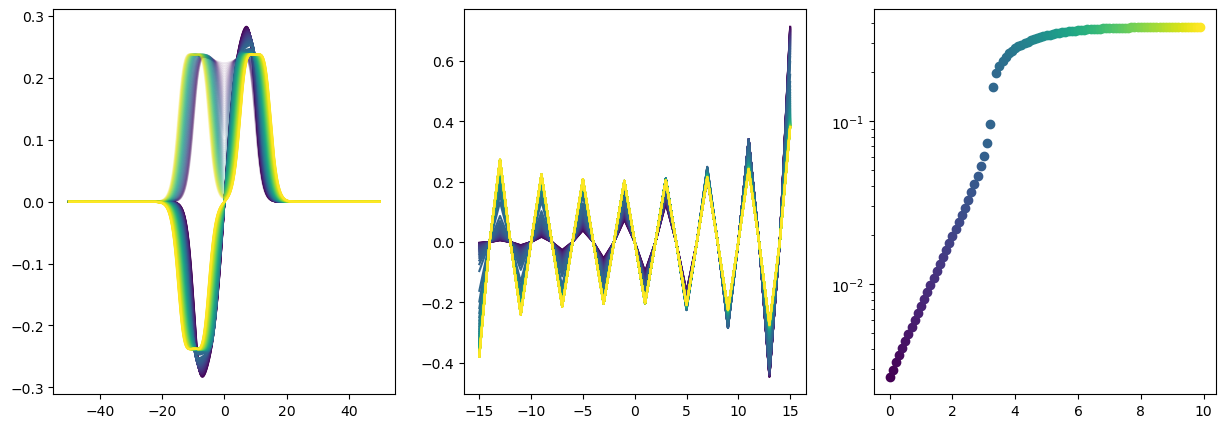

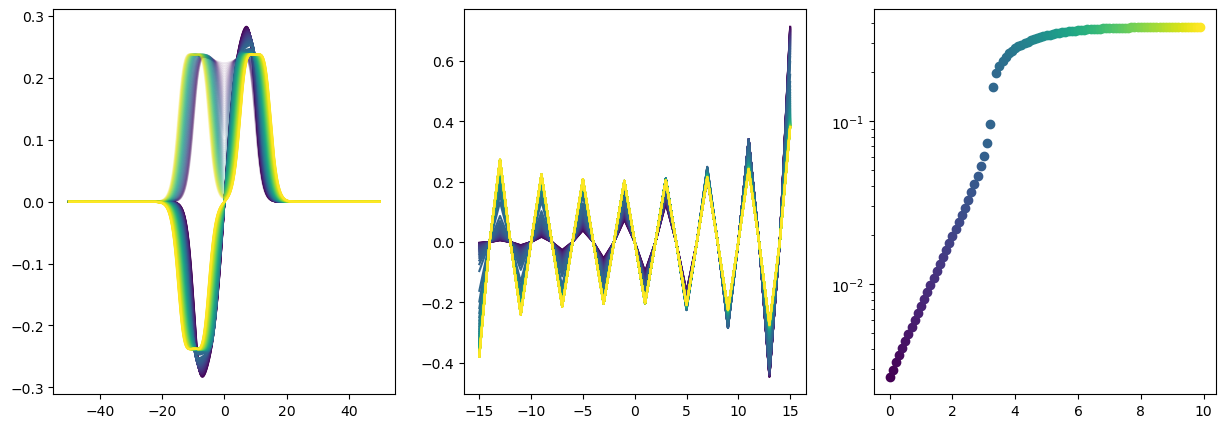

In [3]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

N = 30
xmax = 50
num_points = 2000
num_island = 200 # number of island points
num_junction_list = jnp.arange(0, 200, 2)
Ls = num_junction_list / num_points * 2 * xmax

cmap = plt.get_cmap('viridis', len(Ls))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

coefficients = []
left_modes = []
right_modes = []
maxiter = 5000
tol = 1e-10
verbose = False
initial_guess = jnp.ones(num_points + N + 1, dtype = jnp.float64) # None # np.ones(nx) # np.random.rand(nx) # 
initial_guess = None
for i, num_junction in enumerate(num_junction_list):
    phi_p, phi_m, v = solve(xmax, num_points, num_junction, num_island, N, initial_guess, maxiter = maxiter, tol = tol, verbose = verbose)
    phi_R, phi_L = (phi_p + phi_m)/jnp.sqrt(2), (phi_p - phi_m)/jnp.sqrt(2)
    phi_R *= jnp.sign(phi_R[jnp.argmax(jnp.abs(phi_R))])
    phi_L *= jnp.sign(phi_L[jnp.argmax(jnp.abs(phi_L))])
    coefficients.append(v)
    left_modes.append(phi_L)
    right_modes.append(phi_R)

    nx = num_points
    L = Ls[i]
    initial_guess = jnp.concatenate((phi_p[nx//2:], phi_m[nx//2:], v))
    
    axs[0].plot(jnp.linspace(-xmax, xmax, nx), phi_m, color=cmap(i), label=f"L={L:.1f}")
    axs[0].plot(jnp.linspace(-xmax, xmax, nx), phi_p, color=cmap(i), label=f"L={L:.1f}", alpha = 0.1)

    axs[1].plot(jnp.arange(-N/2, N/2 + 1), v.reshape(len(v)), color=cmap(i), label = f"L={L:.1f}", alpha=1)

    axs[2].scatter(L, jnp.abs(v[0]), color = cmap(i))
    axs[2].set_yscale('log')

    clear_output(wait=True)
    display(fig)
    


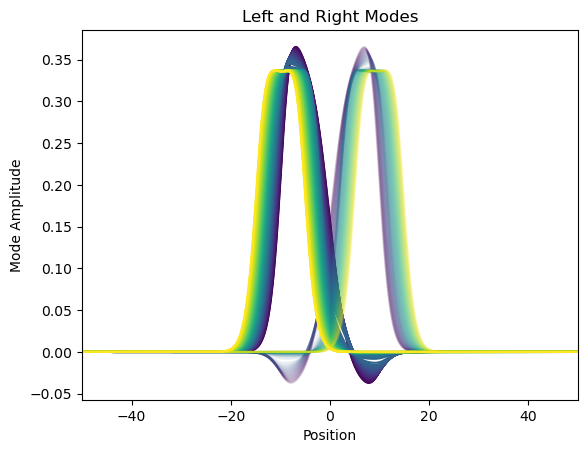

In [5]:
plt.xlim(1.5, 3.5)
for i in range(len(left_modes)):
    plt.plot(jnp.linspace(-xmax, xmax, num_points), left_modes[i], color=cmap(i), label=f'Left Mode L={Ls[i]:.1f}')
    plt.plot(jnp.linspace(-xmax, xmax, num_points), right_modes[i], color=cmap(i), alpha = 0.1, label=f'Right Mode L={Ls[i]:.1f}')
plt.xlim(-xmax, xmax)
plt.xlabel('Position')
plt.ylabel('Mode Amplitude')
plt.title('Left and Right Modes')
#plt.legend()
plt.show()
